In [9]:
import pandas as pd
from shapely import wkt
from dateutil.parser import parse

In [5]:
import requests as rqs

In [41]:
crash = (pd
             .read_csv('../data/maincrime.csv')
             .query("tipo_delito.str.contains('Seg Vial') & timestamp.str.contains('2017')")
             .assign(timestamp = lambda df: df.timestamp.map(parse),
                     geometry = lambda df: df.geometry.map(wkt.loads))
             .reset_index(drop=True)
)

In [3]:
crash.to_csv('../data/crash-2017.csv', index=False)

## Getting street data with reversgeocoding api

In [30]:
import json

In [47]:
def getStreetInfo(latlong):
    api = 'http://ws.usig.buenosaires.gob.ar/geocoder/2.2/'
    address = []
    interse = []
    for pair in latlong:
        x, y = pair
        try:
            response = rqs.get(api + f"reversegeocoding?x={x}&y={y}")
        except:
            address.append('')
            interse.append(999)
            continue
        jsonData = json.loads(response.text[1:-1])
        address.append(jsonData['puerta'])
        interse.append(jsonData['metros_a_esquina'])
    return [address, interse]

In [49]:
points = crash.geometry.map(lambda point: point.coords[0]).tolist()

In [50]:
sites, edges = getStreetInfo(points)

In [52]:
crash = crash.assign(site = sites, edge = edges)

In [54]:
crash.to_csv('../data/crash-2017.csv', index=False)

## Add bikelane data

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [20]:
from shapely.ops import cascaded_union

In [21]:
ciclovias = (pd.read_csv('../data/ciclovias.csv')
               .assign(area = lambda df: df.area.map(wkt.loads), 
                       geometry = lambda df: df.geometry.map(wkt.loads))
)

In [22]:
areas = cascaded_union(ciclovias.area)

In [23]:
bikelane = crash.geometry.map(areas.intersects)

In [24]:
crash = crash.assign(lane = list(map(int, bikelane)))

In [25]:
crash.to_csv('../data/crash-2017.csv', index=False)

In [10]:
crash = crash.assign(geometry = crash.geometry.map(wkt.loads))

In [26]:
geocrash = gpd.GeoDataFrame(crash)
geoareas = gpd.GeoDataFrame(ciclovias, geometry='area')

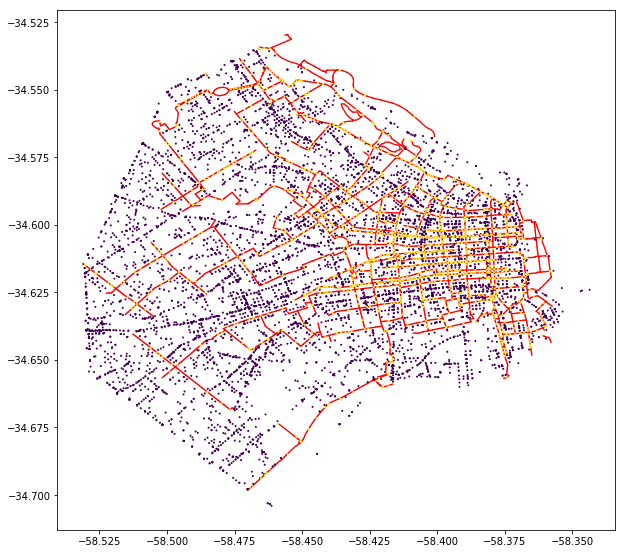

In [29]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
geoareas.plot(color='red', ax=ax)
geocrash.plot(column='lane', markersize=1, ax=ax)

In [33]:
crash.loc[crash.lane==1].shape

(2511, 7)